In [1]:
from google.colab import drive


In [2]:
drive.mount("/gdrive")


Mounted at /gdrive


In [3]:
base_path = '/gdrive/MyDrive/nma_dl_metamorphs/'

In [4]:
!ls $base_path

code  data  dsprite_data_generation.ipynb


# Visualize data

In [5]:
!ls $base_path

code  data  dsprite_data_generation.ipynb


In [6]:
from pathlib import Path

In [7]:
data_path = Path(base_path).joinpath('data/multi_dsprites/processed')


In [8]:
data_path

PosixPath('/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed')

In [9]:
data_files = list(data_path.glob('*'))
print(*data_files, sep="\n") 

/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/training_objcounts_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/training_objareas_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/training_imgareas_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/validation_objcounts_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/validation_objareas_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/validation_imgareas_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/test_objcounts_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/test_objareas_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/test_imgareas_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/training_images_rand4.npy
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/processed/training_masks_rand4.

In [17]:
import numpy as np
train_images = np.load(data_files[-15])
train_labels = np.load(data_files[-13])
val_images = np.load(data_files[-10])
val_labels = np.load(data_files[-8])

In [118]:
# change labels so that they start at 0
train_labels = train_labels.long()-1
val_labels = torch.tensor(val_labels)
val_labels = val_labels.long()-1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [119]:
val_labels

tensor([1, 0, 2,  ..., 0, 3, 3])

In [18]:
train_images.shape

(50000, 64, 64, 3)

In [89]:
train_labels.shape

tensor(1)

In [20]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'count: 4.0')

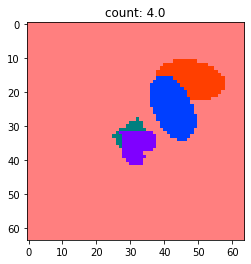

In [21]:
idx = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[idx])
plt.title('count: ' + str(train_labels[idx]))

**Poke around the sprites**

In [64]:
import random
from random import randint, choice

import time

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms

from tqdm.auto import tqdm
import numpy as np
from PIL import Image

# Set manual seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
# Make CUDA operations deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [18]:
data_path = Path(base_path).joinpath('data/multi_dsprites/dsprites-dataset')

In [41]:
data_files = list(data_path.glob('*'))
print(*data_files, sep="\n") 

/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/.git
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/dsprites_reloading_example.ipynb
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/README.md
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/CONTRIBUTING.md
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.hdf5
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/dsprites.gif
/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/LICENSE


In [42]:
dataset_zip = np.load('/gdrive/MyDrive/nma_dl_metamorphs/data/multi_dsprites/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding="latin1")
sprites = dataset_zip['imgs']

In [43]:
def rand_rgb_tuple():
    val = [0, 63, 127, 191, 255]
    return choice(val), choice(val), choice(val)

In [48]:
# params
dataset_size = 64
num_objects = 2
unique = False

# Initialise
all_images = np.zeros((dataset_size, 64, 64, 3))
all_instance_masks = np.zeros((dataset_size, 64, 64, 1))

# Create images
for i in range(dataset_size):
    if (i+1)%10000 == 0:
        print(f"Processing [{i+1} | {dataset_size}]")

    # Create background
    background_colour = rand_rgb_tuple()
    image = np.array(Image.new('RGB', (64, 64), background_colour))
    # Initialise instance masks
    instance_masks = np.zeros((64, 64, 1)).astype('int')

    img_colours = [background_colour]

    # Add objects
    if num_objects is None:
        num_sprites = randint(1, 4)
    else:
        num_sprites = num_objects
    for obj_idx in range(num_sprites):
        object_index = randint(0, 737279)
        sprite_mask = np.array(sprites[object_index], dtype=bool)
        crop_index = np.where(sprite_mask == True)
        object_colour = rand_rgb_tuple()
        # Optional: get new random colour if colour has already been used
        while unique and object_colour in img_colours:
            object_colour = rand_rgb_tuple()
        image[crop_index] = object_colour
        instance_masks[crop_index] = obj_idx + 1
        img_colours.append(object_colour)
    # Collate
    all_images[i] = image
    all_instance_masks[i] = instance_masks

all_images = all_images.astype('float32') / 255.0

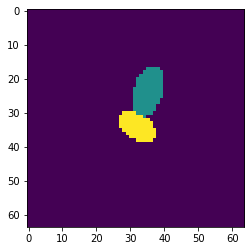

In [49]:
plt.imshow(all_instance_masks[0,:,:,:].squeeze())

In [13]:
!mkdir -p $base_path/code/github
!cd "$base_path/code/github"; git clone https://github.com/kkarbasi/metamorphs.git 

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


**Data Loader**

In [125]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
  """
  Trains the current inpur model using the data
  from Train_loader and Updates parameters for a single pass
  """
  device = args['device']
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    if reg_function1 is None:
      loss = criterion(output, target)
    elif reg_function2 is None:
      loss = criterion(output, target)+args['lambda']*reg_function1(model)
    else:
      loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
    loss.backward()
    optimizer.step()

  return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
  """
  Tests the current Model
  """
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  return 100. * correct / len(test_loader.dataset)


def main(args, model, train_loader, val_loader,
         reg_function1=None, reg_function2=None):
  """
  Trains the model with train_loader and tests the learned model using val_loader
  """

  device = args['device']

  model = model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

  val_acc_list, train_acc_list,param_norm_list = [], [], []
  for epoch in tqdm(range(args['epochs'])):
    trained_model = train(args, model, train_loader, optimizer,
                          reg_function1=reg_function1,
                          reg_function2=reg_function2)
    train_acc = test(trained_model, train_loader, device=device)
    val_acc = test(trained_model, val_loader, device=device)
    # param_norm = calculate_frobenius_norm(trained_model)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    # param_norm_list.append(param_norm)

  return val_acc_list, train_acc_list, trained_model

In [81]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, images, labels, transform=None, target_transform=None):
        # assert all(tensors[0].size[0] == tensor.size[0] for tensor in tensors)
        self.images = images
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x = self.images[index]

        if self.transform:
          x = self.transform(x)

        y = self.img_labels[index]
        if self.target_transform:
          y = self.target_transform(y)

        return x, y

    def __len__(self):
        return len(self.img_labels)

In [82]:
train_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

In [120]:
# put data into 
train_data =  CustomTensorDataset(train_images, train_labels, transform=train_transform)
val_data = CustomTensorDataset(val_images,val_labels,transform=train_transform)

In [127]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()
# Create the corresponding DataLoaders for training and test
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

BATCH_SIZE = 128  # number of examples per minibatch

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           num_workers=0,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=1000,
                                         num_workers=0,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)

Random seed 2021 has been set.


In [128]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 64, 64])
Labels batch shape: torch.Size([16])


In [129]:
class AnimalNet(nn.Module):
  def __init__(self):
    super(AnimalNet, self).__init__()
    self.fc1 = nn.Linear(3 * 64 * 64, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 4)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    output = F.log_softmax(x, dim=1)
    return output

Random seed 2021 has been set.



Time to memorize the dataset: 402.36112451553345


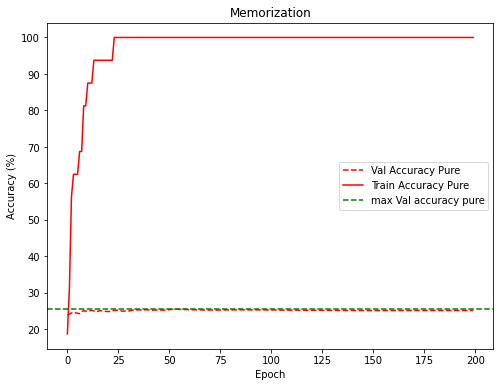

In [132]:
# Here we have 100 true train data.

# Set the arguments
args = {
    'epochs': 200,
    'lr': 5e-3,
    'momentum': 0.9,
    'device': DEVICE
}


# Initialize the network
set_seed(seed=SEED)
model = AnimalNet()

start_time = time.time()
# Train the network
val_acc_pure, train_acc_pure, model = main(args=args,
                                              model=model,
                                              train_loader=train_loader,
                                              val_loader=val_loader)
end_time = time.time()

print(f"Time to memorize the dataset: {end_time - start_time}")

# Train and Test accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(val_acc_pure, label='Val Accuracy Pure', c='red', ls='dashed')
plt.plot(train_acc_pure, label='Train Accuracy Pure', c='red', ls='solid')
plt.axhline(y=max(val_acc_pure), c='green', ls='dashed',
            label='max Val accuracy pure')
plt.title('Memorization')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()